In [1]:
import sys
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/Preprocess')
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/DAlgorithms')

import Preprocessdata
import MySVM as mysvc

In [2]:
from __future__ import print_function
from __future__ import division

import logging
from sklearn.datasets import make_classification
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization
from pandas.core.frame import DataFrame
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report
from scipy.interpolate import spline
from sklearn import metrics
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.gaussian_process import GaussianProcess
import timeit
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.core.pylabtools import figsize
from scipy.interpolate import spline
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
import re
from astropy.io.fits.header import Header
from matplotlib.pyplot import xlim
from sklearn import svm
%matplotlib inline


In [3]:

# Load data set and target values
start = timeit.default_timer()

####### Read the source data######################
df =pd.read_csv('Source_Data.csv', header=0)


p= Preprocessdata.standardprocess()

save_path = '/home/peng/git/Machine_learning_for_reliability_analysis/Kernel/Results/'
result_name = 'j1_rbf_pca_train_v1.csv'

seed = 'rbf'
rad_stat = 2

#train, trainlabel, test, testlabel = p.scaledivd(df, 0.8)
#print (np.shape(train))

In [4]:
#### scale the training dataset first and then apply the rules to test set 
train, trainlabel, test, testlabel = p.sep_scale_divd(df, 0.8)
#print (test[0:10])



In [5]:
## PCA: reduce the dimensions
from sklearn.decomposition import PCA

pca_fit = PCA(n_components=6).fit(train)
pca_train = pca_fit.transform(train)
pca_test = pca_fit.transform(test)

train = pca_train
test = pca_test

In [6]:
# use the new features to train

ff = mysvc.training_manCV()

df = ff.trainauc(train, trainlabel, 'rbf', Cmin=-10, Cmax=10, numC=21, rmin=-10, rmax=10, numr=21, degree = 3,
                rad_stat = rad_stat)

df.to_csv(save_path + 'j1_rbf_pca_train_auc_1.csv', header = True)


0.8014388295
1 cycle finished, 20 left
0.8014388295
2 cycle finished, 19 left
0.8014388295
3 cycle finished, 18 left
0.8014388295
4 cycle finished, 17 left
0.8014388295
5 cycle finished, 16 left
0.8014388295
6 cycle finished, 15 left
0.8014388295
7 cycle finished, 14 left
0.80168718281
8 cycle finished, 13 left
0.810239175035
9 cycle finished, 12 left
0.81479861786
10 cycle finished, 11 left
0.812398769031
11 cycle finished, 10 left
0.807515387107
12 cycle finished, 9 left
0.806605658136
13 cycle finished, 8 left
0.805042651981
14 cycle finished, 7 left
0.803736097614
15 cycle finished, 6 left
0.801317352338
16 cycle finished, 5 left
0.802127200086
17 cycle finished, 4 left
0.79985962639
18 cycle finished, 3 left
0.799973005075
19 cycle finished, 2 left
0.796115430299
20 cycle finished, 1 left
0.796919879063
21 cycle finished, 0 left


In [6]:
df =pd.read_csv(save_path + 'j1_rbf_pca_train_auc_1.csv', header = 0)

In [7]:
df_new = df.drop('gamma_range', 1)
df_new = df_new.drop('Unnamed: 0',1)
list_c = df_new.columns.values.tolist()
idx_C, idx_gamma = [],[]
for i in list_c:
    for j in xrange(0,21):
        if df[i][j]== (df_new.values.max()):
            
            idx_C.append(i)
            idx_gamma.append(j)
        else:
            pass
print (idx_C)
print (idx_gamma)       

['0.5']
[16]


In [8]:
# if only got unique maximum value, then check 

C_best = idx_C[0]
gamma_best = idx_gamma[0]

print (df[C_best][gamma_best], df_new.values.max())
C_best = np.float(C_best)
gamma_best = np.float(gamma_best)

0.868594104308 0.868594104308


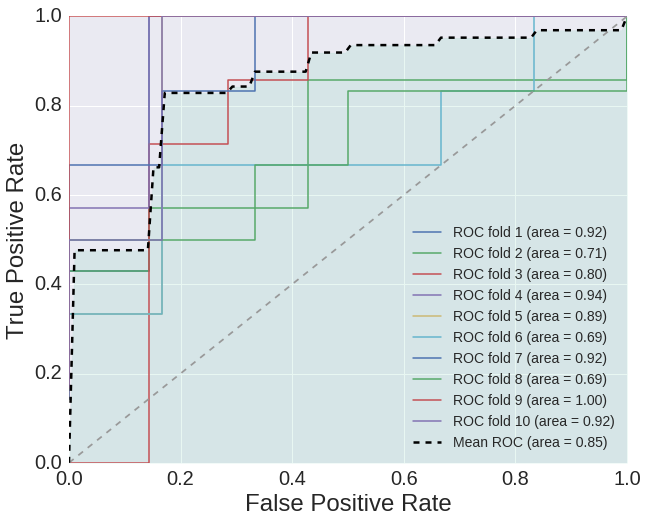

In [9]:
#use the best parameters to plot cv auc on the training set
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

figsize(10,8)
cv = StratifiedKFold(trainlabel, n_folds=10)

bestmodel_training= svm.SVC(kernel=seed, C= C_best, gamma= gamma_best, probability=True, 
                            random_state = rad_stat)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (training, testing) in enumerate(cv):
    probas_ = bestmodel_training.fit(train[training], trainlabel[training]).predict_proba(train[testing])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(trainlabel[testing], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', 
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2.5)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 14)

plt.fill_between(mean_fpr, 0, mean_tpr, #color="#348ABD", 
                 color="#66cdaa", alpha=0.15)
plt.show()

In [10]:
#predict the test set

tt=mysvc.test()
result = tt.test_classification(test, testlabel,bestmodel_training)

This is for test set**************************************
('The accuracy for the test set is 0.78125', 'and the confusion matrix is')
[[12  3]
 [ 4 13]]
             precision    recall  f1-score   support

        0.0       0.80      0.75      0.77        16
        1.0       0.76      0.81      0.79        16

avg / total       0.78      0.78      0.78        32



[[12  3]
 [ 4 13]]
*******************************************


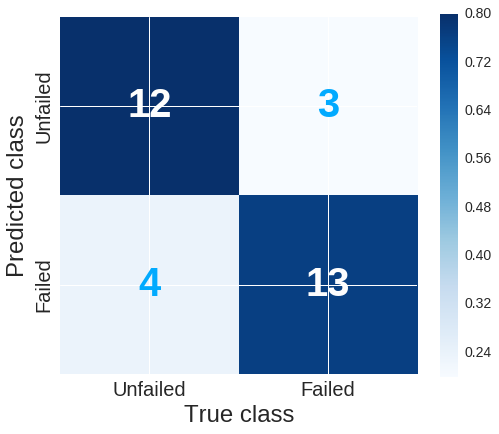

In [11]:
#plot the confusion matrix on test set
import Superplot
from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report
print (confusion_matrix(result, testlabel))
pp = Superplot.fancy()
pp.plot_confusion_matrix(confusion_matrix(result, testlabel))

In [12]:
#plot the auc on test set
from sklearn.metrics import roc_curve, auc

y_score = bestmodel_training.predict_proba(test)
#print (y_score)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

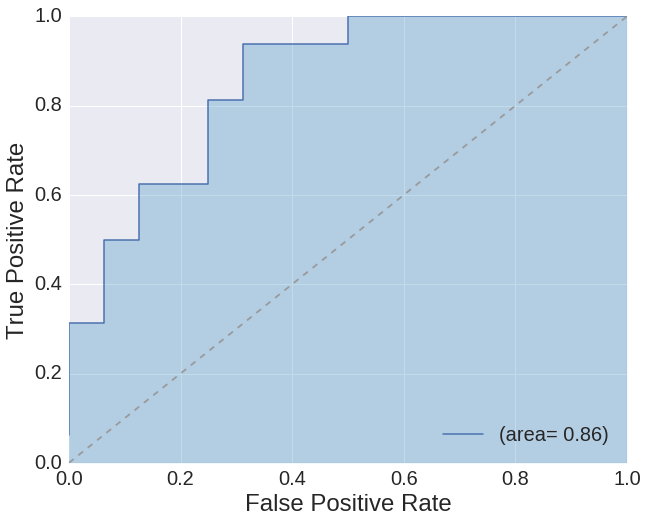

In [17]:
#plot the auc on test set
fpr, tpr, thresholds = roc_curve(testlabel, y_score[:, 1])
roc_auc = auc(fpr, tpr)

figsize(10,8)

plt.plot(fpr, tpr, lw=1.5, label='(area= %0.2f)' % ( roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
#plt.xlim([-0.05, 1.05])
#plt.ylim([-0.05, 1.05])

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 20)
sec = np.arange(0.0, 1.0, 0.05)
plt.fill_between(fpr, 0, tpr, color="#348ABD", alpha=0.3)
plt.show()

In [13]:
df_score = pd.read_csv(save_path + 'y_score_comp.csv', header = 0)

In [14]:
df_score['y_pca']=y_score[:,1]

In [18]:
df_score.to_csv(save_path +'y_score_comp.csv', header = True)